In [1]:
from loguru import logger

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt

from bmws import Observation, sim_and_fit, sim_wf
from bmws.betamix import forward, BetaMixture
from bmws.data import Dataset
from bmws.estimate import empirical_bayes, estimate, jittable_estimate, _beta_pdf
from bmws.sim import sim_admix
rng = np.random.default_rng()

# New data format

Create a list of "records" and then call `data = Dataset.from_records()`. Each record is of the form:

    rec = {
        't': t,  # time of observation (gens before present)
        'theta': theta  # [K] admixture proportions,
        'obs': (n, d)   # tuple: n = # of observed alleles, d = # of derived alleles.
    }
    
(For diploid data, $n=2$, while for pseuodhaploid data $n=1$)

## New objective function
Additional regularization terms have been added. The estimand $\mathbf{s}\in\mathbb{R}^{T\times K}$ is now a matrix with $T$ rows (time points) and $K$ columns/populations. The new objective function is:

$$f(\mathbf{s}) = -\mathrm{loglik}(\text{data}\mid N_e,\mathbf{s}) 
+ \alpha \sum_k \sum_{t=2}^T (s_{k,t} - s_{k,t-1})^2 
+ \beta \sum_t \sum_{k_1,k_2 \in [K]} (s_{k_1,t} - s_{k_2,t})^2 
+ \gamma \Vert \mathbf{s} \Vert_*$$

so:

- $\alpha$ controls smoothness "across time" of the $s_{kt}$ for each population $k$
- $\beta$ controls smoothness "between groups"
- $\gamma$ penalizes the rank of the matrix $s$, setting $\gamma\to\infty$ makes each estimated $s$ become a scalar multiple of the other.

$\beta$ and $\gamma$ sort of aim at the same goal, we'll need to experiment to see which makes more sense.

In [2]:

#Load data
def read_data(pop):

    admixture_proportions=pd.read_csv("data/"+pop+"_sample_info.txt", sep="\t")
    admixture_proportions["generation"]=[int(x) for x in round(admixture_proportions["Date"]/30)]
    admixture_proportions=admixture_proportions[(admixture_proportions['Date'] <=10000)]

    #merge allele counts 
    counts=pd.read_csv("data/"+pop+"_snp_acs.raw", sep=" ")
    snps=list(counts.columns)[6:]
    data=pd.merge(admixture_proportions, counts, on="IID")

    #Parameters for data matrices
    T=max(data["generation"])+1
    N=max(data["generation"].value_counts().values)
    K=admixture_proportions.shape[1]-7
    datasets=[]
    for snp in snps:
        records = []
        for gen, count in data["generation"].value_counts().items():
            this_data=data[data["generation"]==gen]
            M=this_data.shape[0]
            for i in range(M):
                if not this_data[snp].isna().iloc[i]:
                    rec = {'t': gen}
                    rec['obs'] = (1, int(this_data[snp].values[i] / 2))
                    rec['theta'] = [this_data["k"+str(k+1)].iloc[i] for k in range(K-1)]
                    rec['theta'].append(1 - sum(rec['theta']))
                    records.append(rec)
        
        datasets.append(Dataset.from_records(records))
        
    return datasets, snps

In [3]:
#Run analysis - no longer fails!
def run_analysis(data, alpha=1e4, beta=1e4, gamma=0, em_iterations=3):
    M=100
    Ne=np.full([data.T, data.K], 1e4)
    Ne_fit=Ne
    s = np.zeros([data.T, data.K])
    ab = np.ones([2, data.K]) + 1e-4
    estimate_kwargs={"alpha": alpha, "beta": beta, "gamma": gamma}

#    with jax.debug_nans(True):
#        for i in range(em_iterations):
#            logger.info("EM iteration {}", i)
#            ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
#            logger.info("ab: {}", ab)
#            s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
#            logger.info("s: {}", s)

    for i in range(em_iterations):
        ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
        s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
            
    return s

snp_4_100142302_C(/A)
snp_4_100142302_C(/A)
rs17843625_G(/A)
rs17843625_G(/A)
rs10829106_C(/T)
rs10829106_C(/T)
rs174548_C(/G)
rs174548_C(/G)
rs12913832_G(/A)
rs12913832_G(/A)
rs2333656_T(/C)
rs2333656_T(/C)


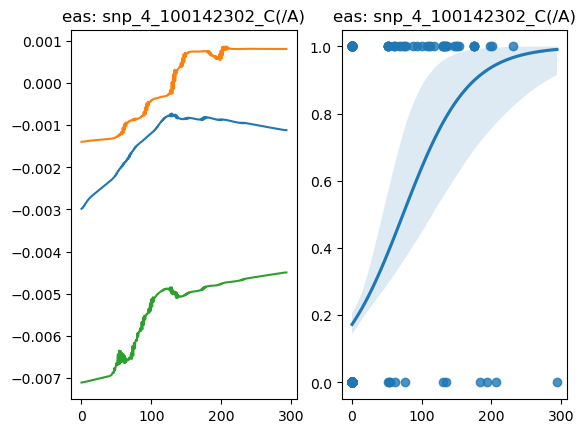

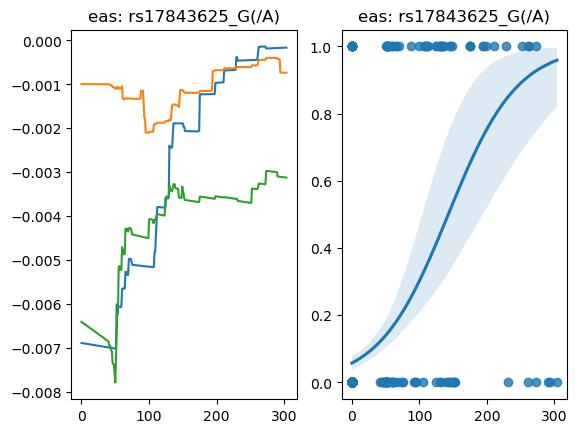

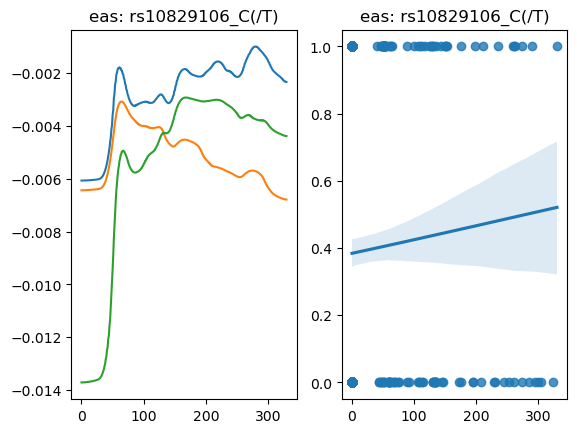

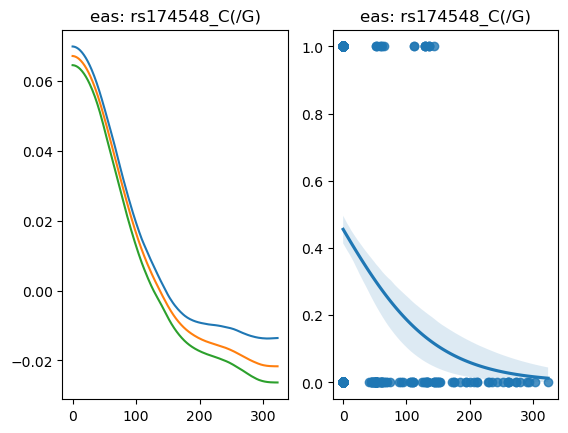

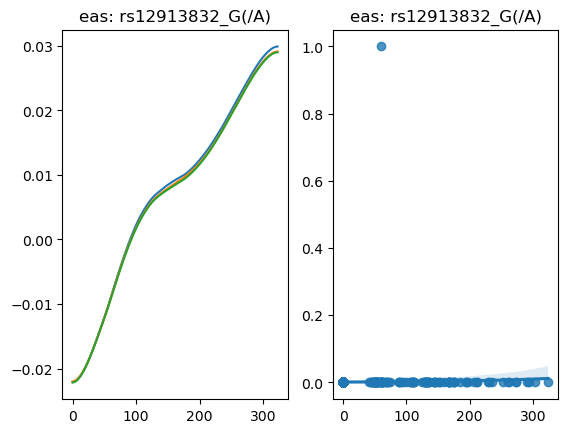

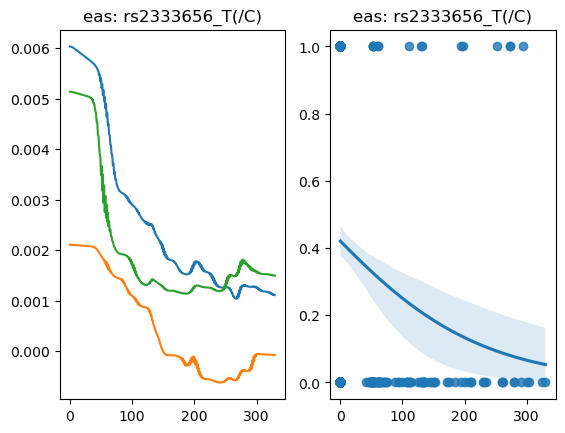

In [10]:
#Run for all EAS SNPs
"""
pop="eas"
datasets, snps=read_data(pop)
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e4, beta=1e2, em_iterations=3)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        axs[0].plot(s[:, 2], color="tab:green", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
        print(snp)
    except:
        print("Error: "+ snp)

"""

rs4988235_A(/G)
rs2245556_T(/C)
rs160578_G(/A)
rs16891982_C(/G)
rs3091338_T(/C)
rs6555913_G(/A)
rs17843625_G(/A)
rs174548_G(/C)
rs12913832_A(/G)
rs1426654_G(/A)
rs7225592_A(/G)


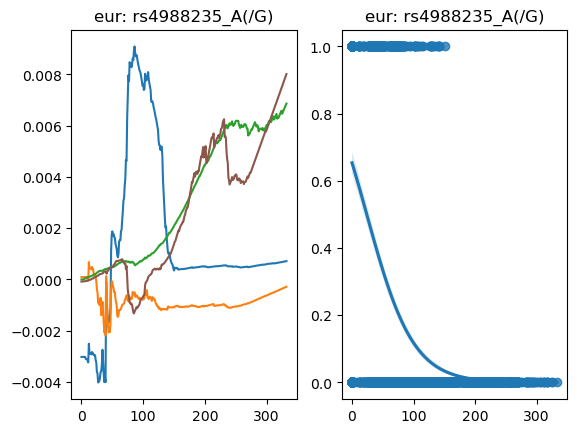

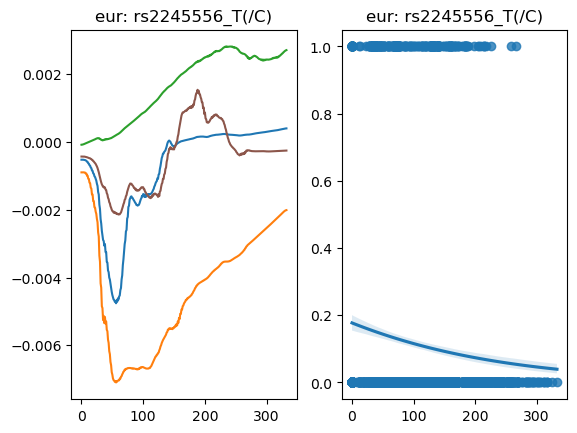

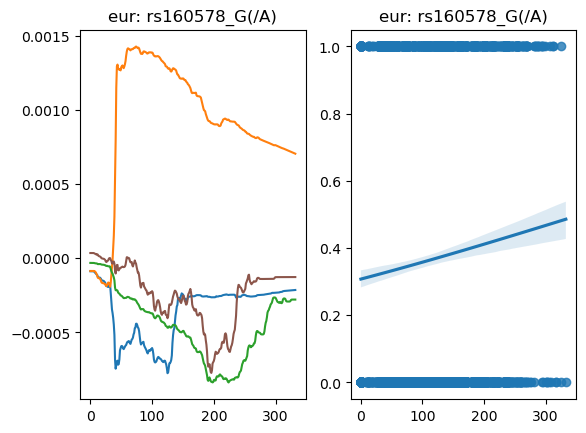

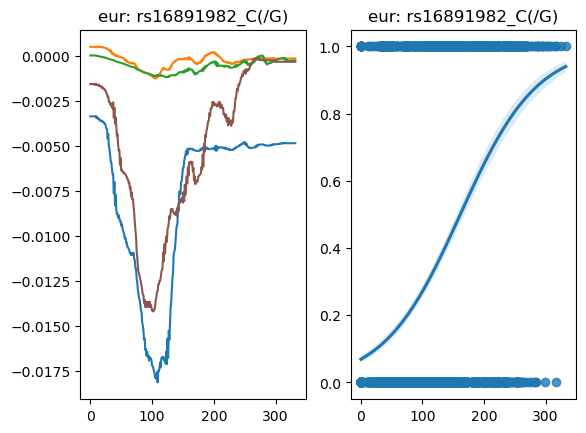

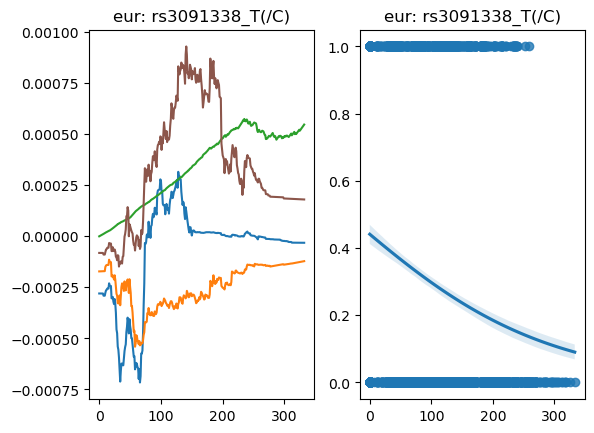

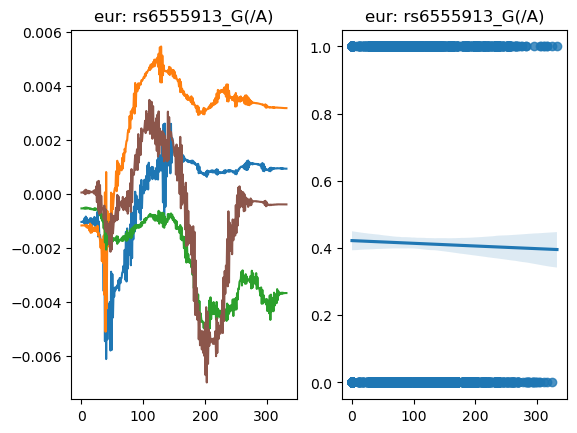

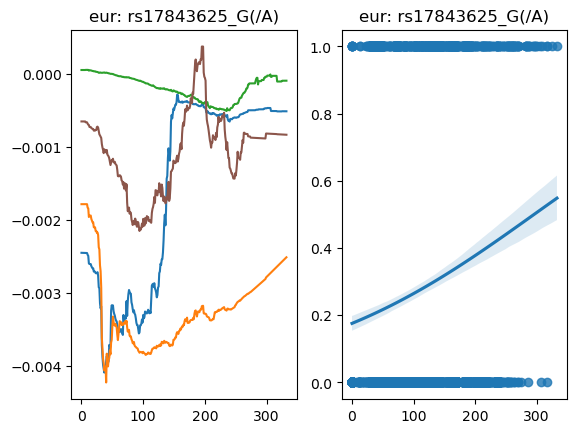

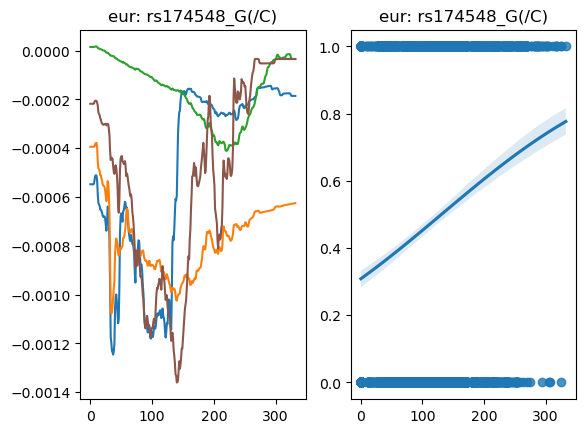

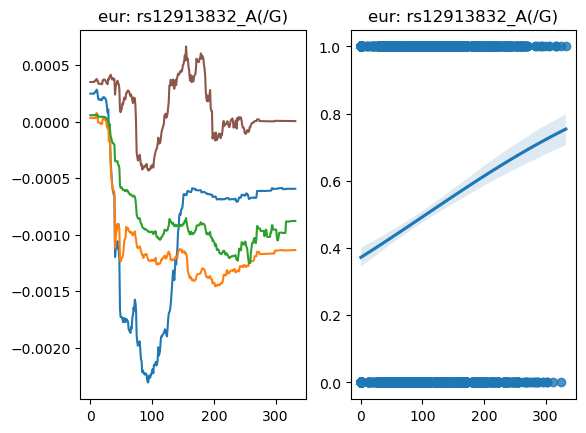

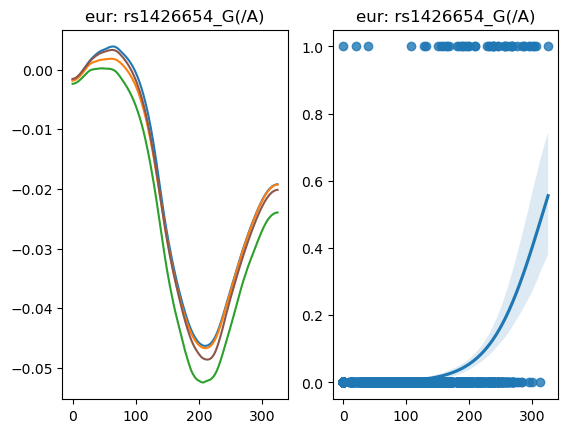

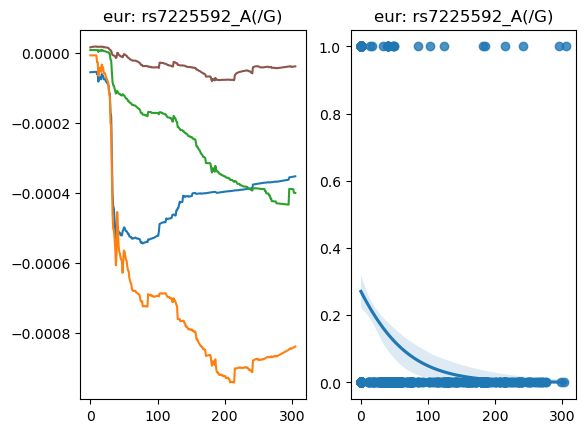

In [15]:
#Run for all EUR SNPs
"""
pop="eur"
datasets, snps=read_data(pop)
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e4, beta=1e2, em_iterations=3)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        axs[0].plot(s[:, 2], color="tab:green", alpha=1)
        axs[0].plot(s[:, 3], color="tab:brown", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
    except:
        print("Error: "+ snp)
"""

rs17843625_G(/A)
rs199959180_A(/G)


/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod

/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod

/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod

rs2072786_C(/G)
rs6001841_G(/A)


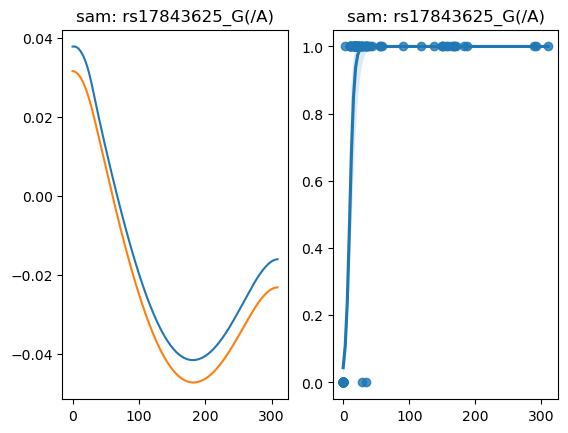

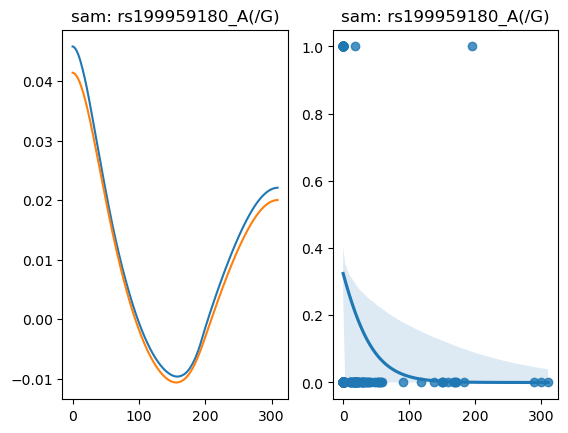

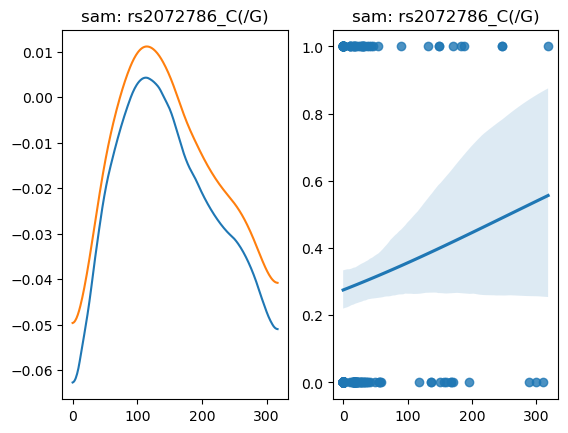

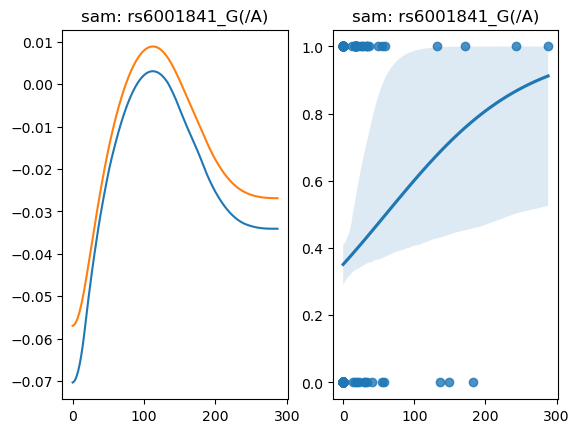

In [16]:
#Run for all SAM SNPs
"""
pop="sam"
datasets, snps=read_data(pop)
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e4, beta=1e2, em_iterations=3)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
    except:
        print("Error: "+ snp)
"""

rs1426654_G(/A)


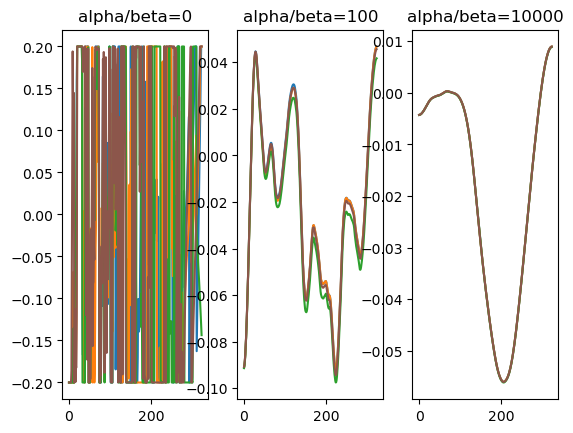

In [9]:
#Show how absolute value of s_hat depends on smoothing paramter. 
pop="eur"
datasets, snps=read_data(pop)
data=datasets[9]
snp=snps[9]
print(snp)
ss=[]
lams=[0,100,10000]
fig, axs = plt.subplots(ncols=len(lams), nrows=1)
for i,lam in enumerate(lams):
    s=run_analysis(data, alpha=lam, beta=lam, em_iterations=3)
    axs[i].plot(s[:, 0], color="tab:blue", alpha=1)
    axs[i].plot(s[:, 1], color="tab:orange", alpha=1)
    axs[i].plot(s[:, 2], color="tab:green", alpha=1)
    axs[i].plot(s[:, 3], color="tab:brown", alpha=1)
    axs[i].set_title("alpha/beta="+str(lam))


rs4988235_A(/G)


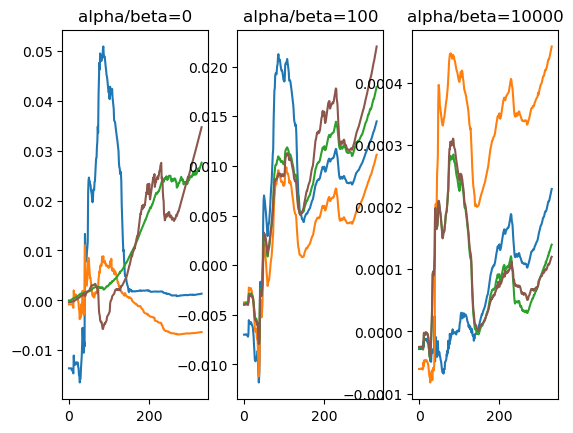

In [11]:
#Show how absolute value of s_hat depends on smoothing paramter. 
pop="eur"
datasets, snps=read_data(pop)
data=datasets[0]
snp=snps[0]
print(snp)
ss=[]
lams=[0,100,10000]
fig, axs = plt.subplots(ncols=len(lams), nrows=1)
for i,lam in enumerate(lams):
    s=run_analysis(data, alpha=lam, beta=lam, em_iterations=3)
    axs[i].plot(s[:, 0], color="tab:blue", alpha=1)
    axs[i].plot(s[:, 1], color="tab:orange", alpha=1)
    axs[i].plot(s[:, 2], color="tab:green", alpha=1)
    axs[i].plot(s[:, 3], color="tab:brown", alpha=1)
    axs[i].set_title("alpha/beta="+str(lam))


rs4988235_A(/G)


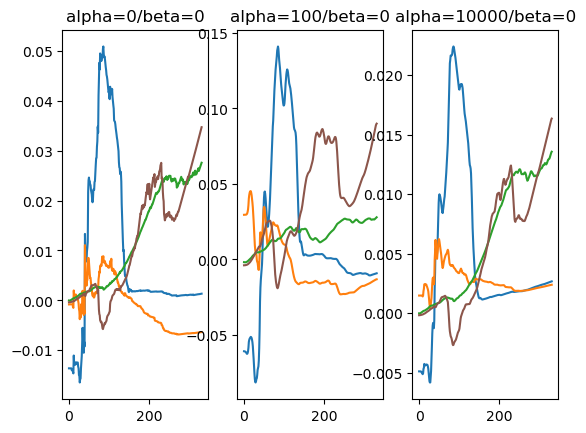

In [10]:
#Show how absolute value of s_hat depends on smoothing paramter. 
pop="eur"
datasets, snps=read_data(pop)
data=datasets[0]
snp=snps[0]
print(snp)
ss=[]
lams=[0,100,10000]
fig, axs = plt.subplots(ncols=len(lams), nrows=1)
for i,lam in enumerate(lams):
    s=run_analysis(data, alpha=lam, beta=0, em_iterations=3)
    axs[i].plot(s[:, 0], color="tab:blue", alpha=1)
    axs[i].plot(s[:, 1], color="tab:orange", alpha=1)
    axs[i].plot(s[:, 2], color="tab:green", alpha=1)
    axs[i].plot(s[:, 3], color="tab:brown", alpha=1)
    axs[i].set_title("alpha="+str(lam)+"/beta=0")


rs4988235_A(/G)


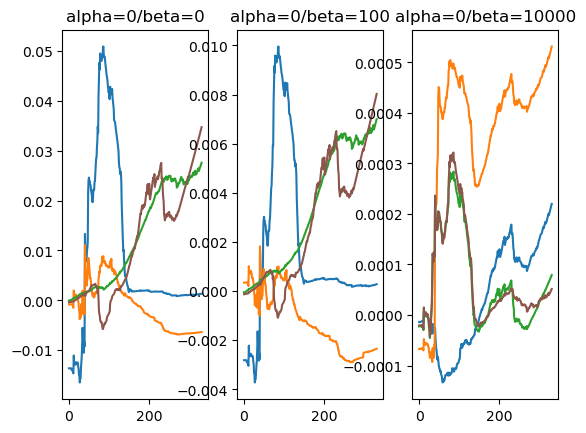

In [6]:
#Show how absolute value of s_hat depends on smoothing paramter. 
pop="eur"
datasets, snps=read_data(pop)
data=datasets[0]
snp=snps[0]
print(snp)
ss=[]
lams=[0,100,10000]
fig, axs = plt.subplots(ncols=len(lams), nrows=1)
for i,lam in enumerate(lams):
    s=run_analysis(data, alpha=0, beta=lam, em_iterations=3)
    axs[i].plot(s[:, 0], color="tab:blue", alpha=1)
    axs[i].plot(s[:, 1], color="tab:orange", alpha=1)
    axs[i].plot(s[:, 2], color="tab:green", alpha=1)
    axs[i].plot(s[:, 3], color="tab:brown", alpha=1)
    axs[i].set_title("alpha=0"+"/beta="+str(lam))
